In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('flood_dataset.csv')

In [3]:
df.head()

,Latitude,Longitude,Rainfall (mm),Temperature (°C),Humidity (%),River Discharge (m³/s),Water Level (m),Elevation (m),Land Cover,Soil Type,Population Density,Infrastructure,Historical Floods,Flood Occurred
0,18.861663,78.835584,218.999493,34.144337,43.912963,4236.182888,7.415552,377.465433,Water Body,Clay,7276.742184,1,0,1
1,35.570715,77.654451,55.353599,28.778774,27.585422,2472.585219,8.811019,7330.608875,Forest,Peat,6897.736956,0,1,0
2,29.227824,73.108463,103.991908,43.934956,30.108738,977.328053,4.631799,2205.873488,Agricultural,Loam,4361.518494,1,1,1
3,25.361096,85.610733,198.984191,21.569354,34.453690,3683.208933,2.891787,2512.277800,Desert,Sandy,6163.069701,1,1,0
4,12.524541,81.822101,144.626803,32.635692,36.292267,2093.390678,3.188466,2001.818223,Agricultural,Loam,6167.964591,1,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Latitude                10000 non-null  float64
 1   Longitude               10000 non-null  float64
 2   Rainfall (mm)           10000 non-null  float64
 3   Temperature (°C)        10000 non-null  float64
 4   Humidity (%)            10000 non-null  float64
 5   River Discharge (m³/s)  10000 non-null  float64
 6   Water Level (m)         10000 non-null  float64
 7   Elevation (m)           10000 non-null  float64
 8   Land Cover              10000 non-null  object 
 9   Soil Type               10000 non-null  object 
 10  Population Density      10000 non-null  float64
 11  Infrastructure          10000 non-null  int64  
 12  Historical Floods       10000 non-null  int64  
 13  Flood Occurred          10000 non-null  int64  
dtypes: float64(9), int64(3), object(2)
memo

In [5]:
df["Flood Occurred"].value_counts()

,count
Flood Occurred,
1,5057
0,4943


In [6]:
df = pd.get_dummies(
    df,
    columns=["Land Cover", "Soil Type"],
    drop_first=True
)

In [7]:
X = df[
    [
        "Rainfall (mm)",
        "River Discharge (m³/s)",
        "Water Level (m)",
        "Elevation (m)",
        "Historical Floods"
    ]
]

In [8]:
X_train_raw, X_test_raw = train_test_split(
    X,
    test_size=0.2,
    random_state=42
)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

In [10]:
kmeans = KMeans(n_clusters=3, random_state=42)
train_clusters = kmeans.fit_predict(X_train_scaled)

In [11]:
test_clusters = kmeans.predict(X_test_scaled)

In [12]:
X_train_df = X_train_raw.copy()
X_train_df["Cluster"] = train_clusters

In [13]:
cluster_summary = X_train_df.groupby("Cluster").mean()
print(cluster_summary)

         Rainfall (mm)  River Discharge (m³/s)  Water Level (m)  \
Cluster                                                           
0           149.307605             2525.105373         5.087055   
1           155.836245             2608.089495         2.473469   
2           145.943405             2414.743360         7.456007   

         Elevation (m)  Historical Floods  
Cluster                                    
0          4432.891403                0.0  
1          4473.666037                1.0  
2          4316.691582                1.0  


In [14]:
risk_mapping = {
    0: "Low",
    1: "Medium",
    2: "High"
}

In [15]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Rainfall (mm)           8000 non-null   float64
 1   River Discharge (m³/s)  8000 non-null   float64
 2   Water Level (m)         8000 non-null   float64
 3   Elevation (m)           8000 non-null   float64
 4   Historical Floods       8000 non-null   int64  
 5   Cluster                 8000 non-null   int32  
dtypes: float64(4), int32(1), int64(1)
memory usage: 406.2 KB


In [16]:
X_train = X_train_raw.copy()
X_test = X_test_raw.copy()

In [17]:
y_train = train_clusters
y_test = test_clusters

In [18]:
models = {
    "Logistic Regression": LogisticRegression(
        random_state=42,
        max_iter=500
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=5,
        max_depth=2,
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=3,
        max_depth=2,
        random_state=42
    ),

    "XGBoost": XGBClassifier(
      n_estimators=25,
      max_depth=2,
      learning_rate=0.2,
      subsample=0.8,
      colsample_bytree=0.8,
      objective="multi:softprob",
      num_class=3,
      random_state=42
  )
}

In [19]:
results = []

for name, model in models.items():

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    recall_macro = recall_score(y_test, y_pred, average="macro")

    results.append([
        name,
        acc,
        f1,
        recall_macro,
    ])

    print(f"\n{name} Results:")
    print("Accuracy:", acc)
    print("F1 Macro:", f1)
    print("Recall Macro:", recall_macro)
    print(classification_report(y_test, y_pred))


Logistic Regression Results:
Accuracy: 0.979
F1 Macro: 0.9724946637486153
Recall Macro: 0.9729733906109961
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       982
           1       0.98      0.94      0.96       524
           2       0.93      0.98      0.96       494

    accuracy                           0.98      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.98      0.98      0.98      2000


Random Forest Results:
Accuracy: 0.983
F1 Macro: 0.9797769203260372
Recall Macro: 0.9776375024466627
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       982
           1       0.98      0.97      0.98       524
           2       0.98      0.96      0.97       494

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


Gradient Boosting Results:


In [20]:
results_df = pd.DataFrame(
    results,
    columns=[
        "Model",
        "Accuracy",
        "F1 Macro",
        "Recall Macro"
    ]
)

print("\nFinal Comparison Table (Sorted by Recall Macro):\n")
print(results_df.sort_values(by="Recall Macro", ascending=False))


Final Comparison Table (Sorted by Recall Macro):

                 Model  Accuracy  F1 Macro  Recall Macro
3              XGBoost    0.9885  0.984927      0.984983
2    Gradient Boosting    0.9865  0.982304      0.982322
1        Random Forest    0.9830  0.979777      0.977638
0  Logistic Regression    0.9790  0.972495      0.972973


In [21]:
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(name, "CV Accuracy:", scores.mean())

Logistic Regression CV Accuracy: 0.991
Random Forest CV Accuracy: 0.986
Gradient Boosting CV Accuracy: 0.98475
XGBoost CV Accuracy: 0.98925


In [22]:
# Training accuracy
train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)

# Test accuracy
test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)

print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Training Accuracy: 0.99075
Test Accuracy: 0.9885


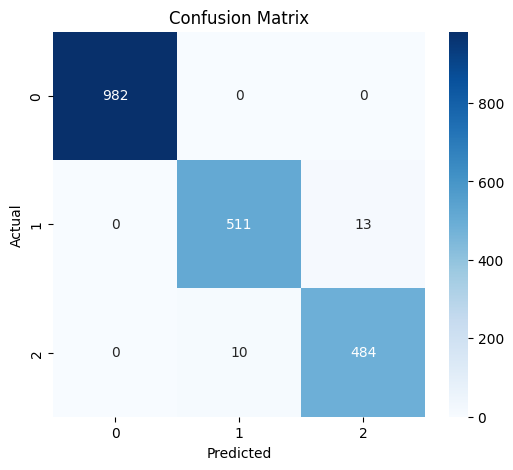

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

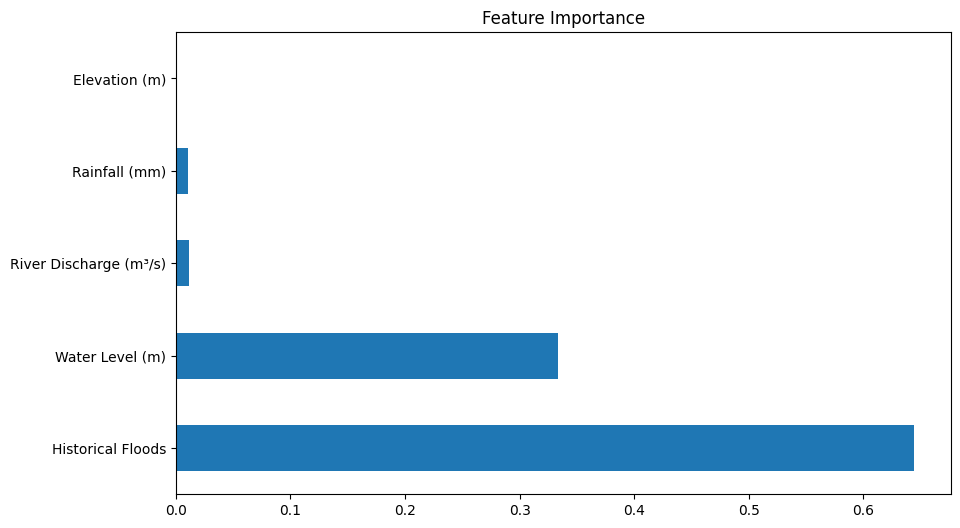

In [24]:
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

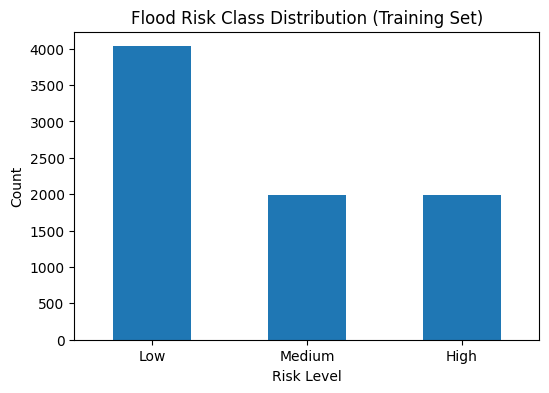

In [25]:
risk_labels = pd.Series(y_train).map(risk_mapping)

risk_counts = risk_labels.value_counts()

plt.figure(figsize=(6,4))
risk_counts.plot(kind="bar")
plt.title("Flood Risk Class Distribution (Training Set)")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train_scaled)

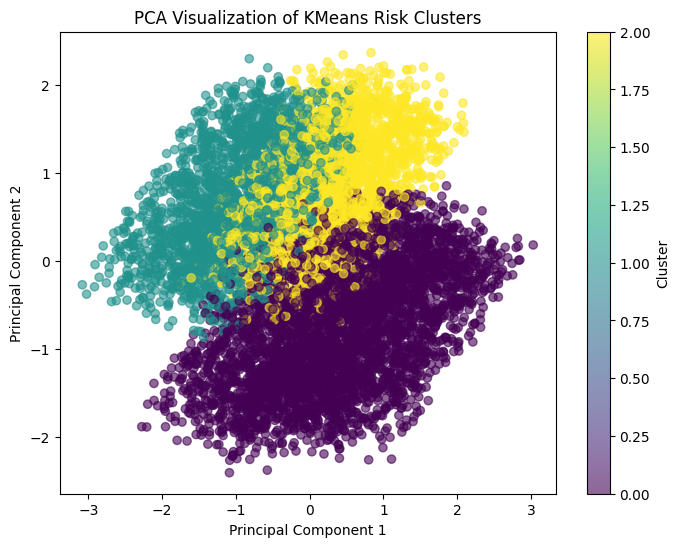

In [29]:
plt.figure(figsize=(8,6))

scatter = plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=train_clusters,
    cmap="viridis",
    alpha=0.6
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of KMeans Risk Clusters")
plt.colorbar(scatter, label="Cluster")
plt.show()

In [30]:
xgb = XGBClassifier(
      n_estimators=25,
      max_depth=2,
      learning_rate=0.2,
      subsample=0.8,
      colsample_bytree=0.8,
      objective="multi:softprob",
      num_class=3,
      random_state=42
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=25,
              n_jobs=None, num_class=3, ...)

In [31]:
y_pred = xgb.predict(X_test)

In [32]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9885
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       982
           1       0.98      0.98      0.98       524
           2       0.97      0.98      0.98       494

    accuracy                           0.99      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



In [33]:
import joblib

joblib.dump(xgb, "flood_risk_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(kmeans, "kmeans_model.pkl")

['kmeans_model.pkl']